In [5]:
from tqdm import tqdm
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from load_data.prepared_custom_ds import CustomDataset
from utilities.config_load import load_config
from utilities.RecallAndPrecision import Metrics
from sklearn.model_selection import train_test_split
from utilities.pkl import get_pkl
from models.small_model import Model_Unet
from utilities.weighted_cross_entropy import weighted_cross_entropy

In [6]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
CONFIG_PATH = "configs/"
config = load_config(CONFIG_PATH, "config.yaml")
img_ids = get_pkl(config['dataset']['index_path'])
mask_ids = [name + ".npy" for name in img_ids]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(img_ids, 
                                                    mask_ids, 
                                                    test_size=0.05,
                                                    random_state=42)

In [10]:
test_masks = list()
for mask in tqdm(y_test):
    test_masks.append(np.load(config['dataset']['mask_path'] + "/" + mask))

100%|██████████████████████████████████████████████████████████████████████████████| 3347/3347 [00:34<00:00, 97.04it/s]


In [11]:
model = Model_Unet(kernel_size=config['model']['kernel_size'], 
                   dropout_rate=config['model']['dropout_rate'], 
                   nkernels=config['model']['nkernels'], 
                   output_chanels=config['model']['output_chanels'])

In [12]:
model.to(device)
pass

In [13]:
model.load_state_dict(torch.load('model_svs/test_try_20240707_194916_8'))
model.eval()
pass

# Statistics

In [23]:
dataset = CustomDataset(config, X_test, test_masks)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=72, num_workers=0, shuffle=True)

In [24]:
loss_fn = weighted_cross_entropy

In [38]:
def test(model, dataloader, loss_fn):
    metrics_valid = Metrics()
    vloss = 0
    counter = 0
    with torch.inference_mode():
        for i, vdata in tqdm(enumerate(dataloader), total=3347//72):
            vfeatures, vlabels = vdata
            vfeatures, vlabels = vfeatures.to(device), vlabels.to(device)
            y_pred = model(vfeatures)
            bloss, y_pred = loss_fn(torch.flatten(y_pred), torch.flatten(vlabels))
    
            vloss += bloss
            y_pred = (y_pred >= 0.98).float()
            metrics_valid.batch_step(torch.flatten(vlabels), y_pred)
            counter = i
            
    avg_vloss = vloss / (counter + 1)
    valrecall, valprecision, valmetr = metrics_valid.get_metrics()
    print('LOSS test {}'.format(avg_vloss))
    print('Recall test {}'.format(valrecall))
    print('Precision test {}'.format(valprecision))
    print('Test TP->{} | FN ->{}| FP->{} | TN->{}'.format(*valmetr))
    
    dice, iou = metrics_valid.get_metrics_dice_iou()
    print('Dice test {}'.format(dice))
    print('IoU test {}'.format(iou))

In [39]:
test(model, dataloader, loss_fn) # 0.98

47it [00:14,  3.26it/s]                                                                                                

LOSS test 0.0040710256434977055
Recall test 0.7976382970809937
Precision test 0.7942672967910767
Test TP->4538703.0 | FN ->1151474.0| FP->1175624.0 | TN->212483184.0
Dice test 0.7959492144507118
IoU test 0.6610594987869263


In [35]:
test(model, dataloader, loss_fn) # 0.97

47it [00:14,  3.25it/s]                                                                                                

LOSS test 0.004152705892920494
Recall test 0.8359184861183167
Precision test 0.7555404901504517
Test TP->4756524.0 | FN ->933653.0| FP->1539001.0 | TN->212119856.0
Dice test 0.7936996931844292
IoU test 0.6579619646072388


In [33]:
test(model, dataloader, loss_fn) # 0.95

47it [00:14,  3.24it/s]                                                                                                

LOSS test 0.004101817961782217
Recall test 0.8776452541351318
Precision test 0.7012357711791992
Test TP->4993957.0 | FN ->696220.0| FP->2127695.0 | TN->211531056.0
Dice test 0.7795853347714834
IoU test 0.6387872695922852


In [30]:
test(model, dataloader, loss_fn) # 0.9

47it [00:14,  3.24it/s]                                                                                                

LOSS test 0.004089275375008583
Recall test 0.9231700301170349
Precision test 0.6207621693611145
Test TP->5253001.0 | FN ->437176.0| FP->3209179.0 | TN->210449648.0
Dice test 0.7423499845290787
IoU test 0.590267539024353


In [28]:
test(model, dataloader, loss_fn) # 0.8

47it [00:14,  3.20it/s]                                                                                                

LOSS test 0.0040873209945857525
Recall test 0.9576155543327332
Precision test 0.5288838744163513
Test TP->5449002.0 | FN ->241175.0| FP->4853831.0 | TN->208804992.0
Dice test 0.6814229466498176
IoU test 0.5167865753173828


In [26]:
test(model, dataloader, loss_fn) # 0.7

47it [00:17,  2.74it/s]                                                                                                

LOSS test 0.004107742570340633
Recall test 0.9733082056045532
Precision test 0.46481630206108093
Test TP->5538296.0 | FN ->151881.0| FP->6376725.0 | TN->207282112.0
Dice test 0.6291659997234907
IoU test 0.45896586775779724


In [13]:
test(model, dataloader, loss_fn) # 0.5

47it [00:15,  2.96it/s]                                                                                                

LOSS test 0.004111302550882101
Recall test 0.9849419593811035
Precision test 0.389611154794693
Test TP->5604494.0 | FN ->85683.0| FP->8780346.0 | TN->204878464.0
Dice test 0.5583550937964337
IoU test 0.3873041868209839


# 10 img

In [14]:
test_imgs = list()
for img_id in tqdm(X_test[0:10]):
    image = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + img_id)                                    
    tens_img = torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float32)  
    norm_image = tens_img / 127.5 - 1
    test_imgs.append(norm_image)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 150.65it/s]


In [15]:
batch_tensor = torch.stack(test_imgs).to(device)

In [16]:
with torch.no_grad():  # Disable gradient calculation for inference
    first_ten_img = model(batch_tensor)

In [17]:
first_ten_img = torch.nn.functional.sigmoid(first_ten_img)

In [18]:
first_ten_img = (first_ten_img >= 0.7).float()

In [19]:
first_ten_img = first_ten_img.numpy(force=True)

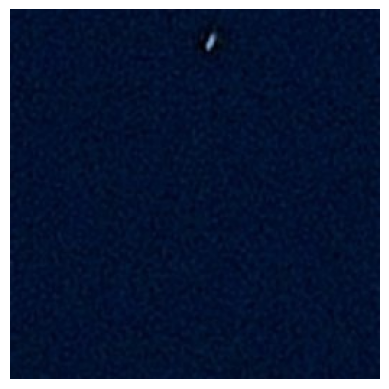

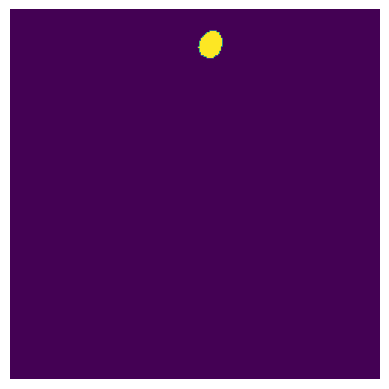

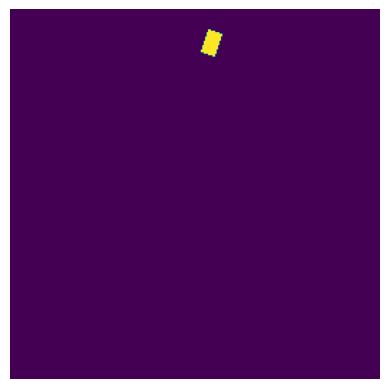

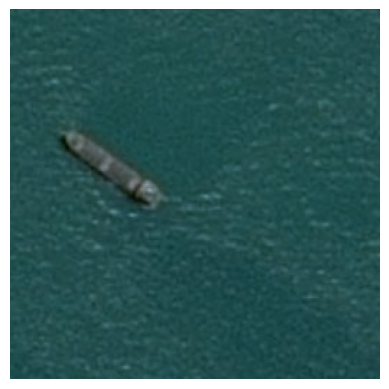

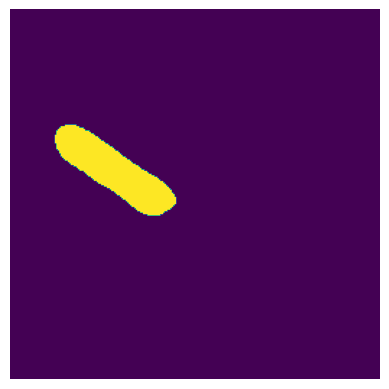

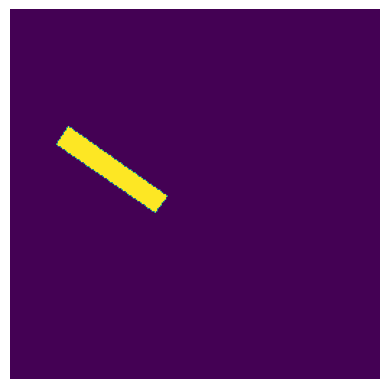

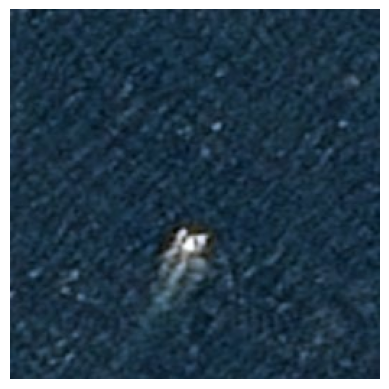

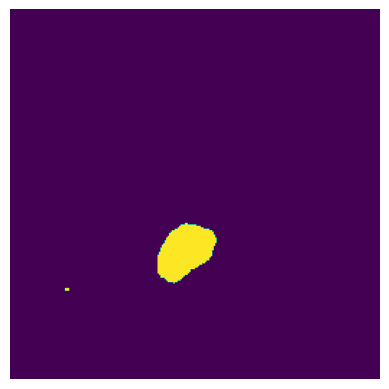

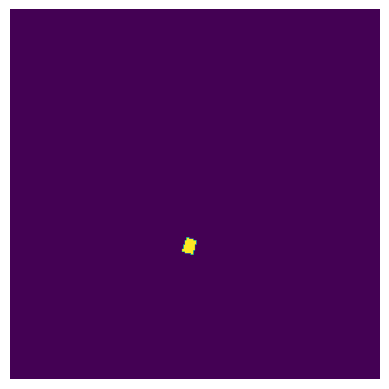

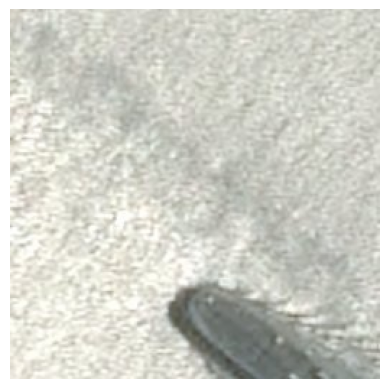

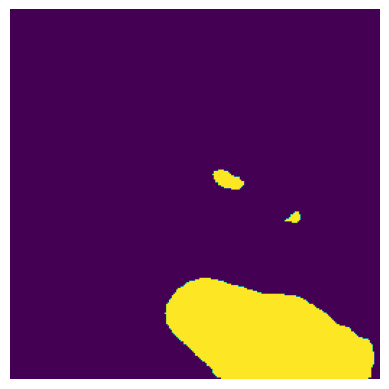

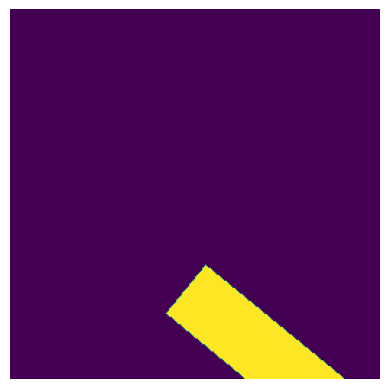

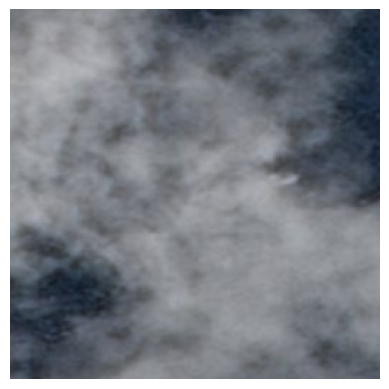

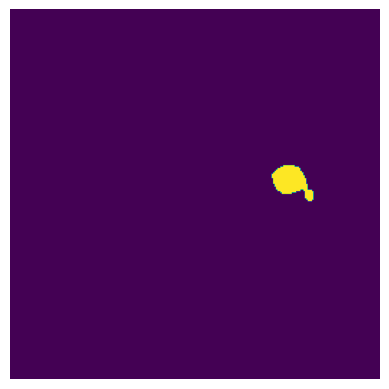

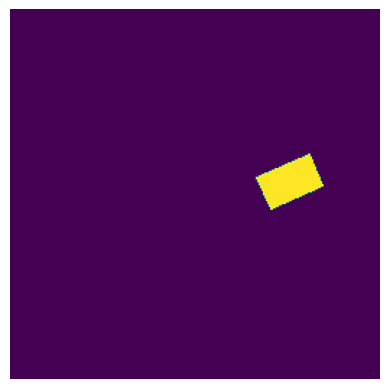

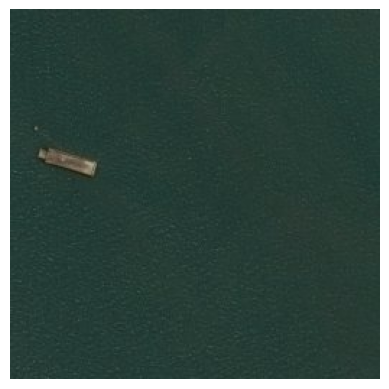

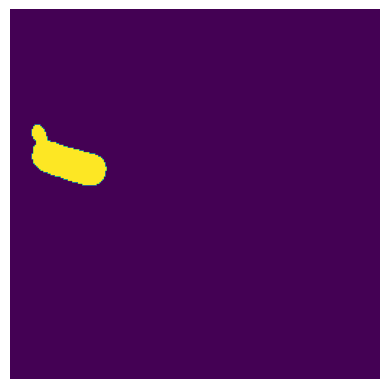

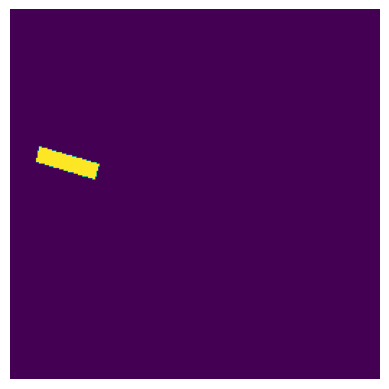

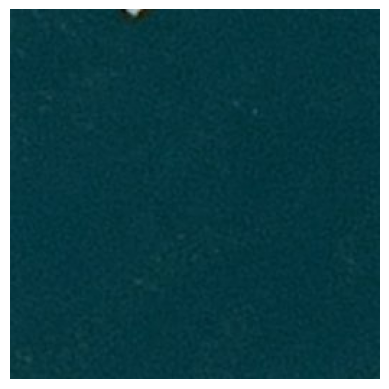

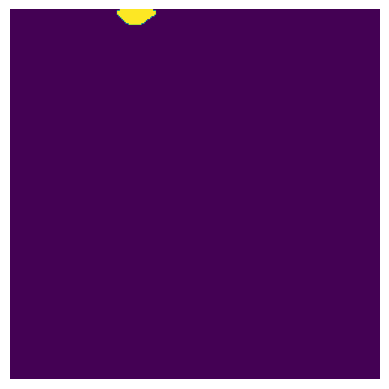

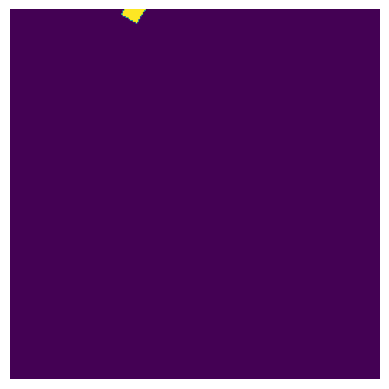

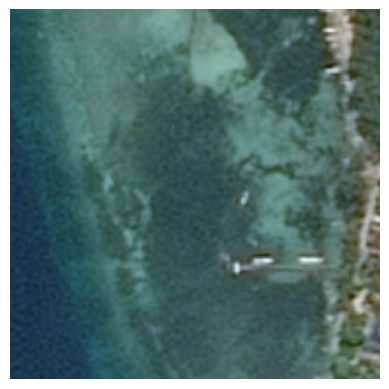

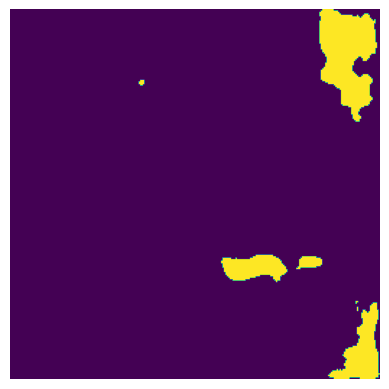

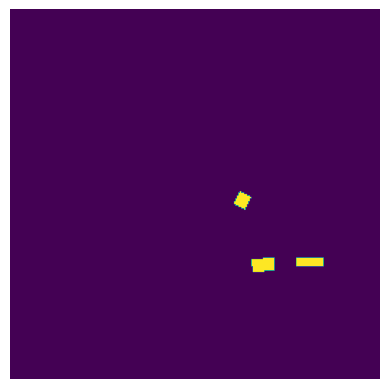

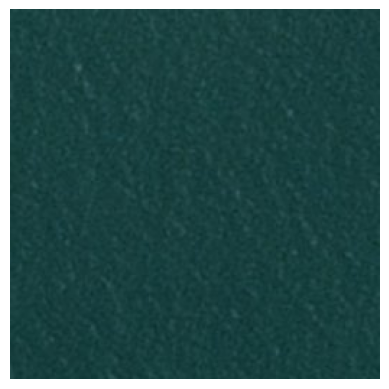

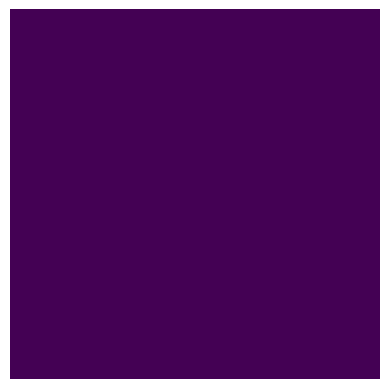

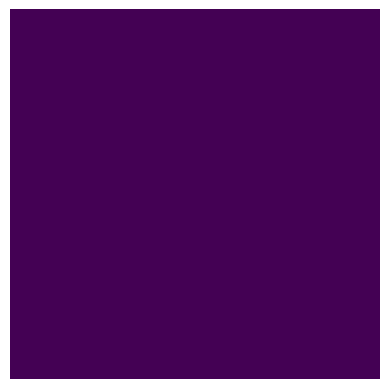

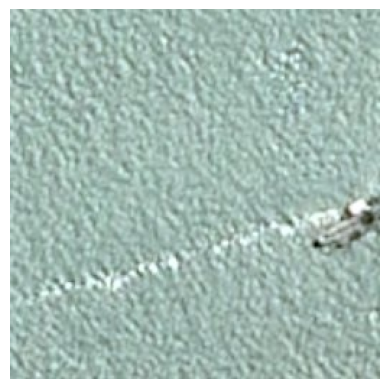

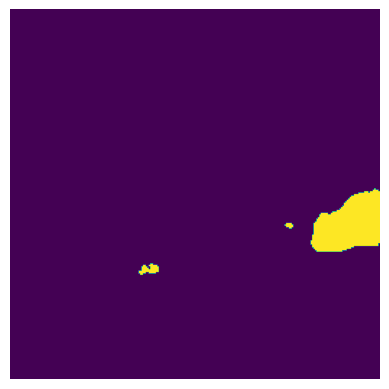

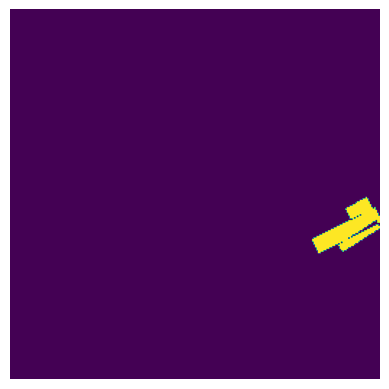

In [20]:
for orign, img, mask in zip(X_test[0:10], first_ten_img, test_masks[0:10]):
    image = cv2.imread(config['dataset']['reshaped_img_path'] + "/" + orign)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

In [4]:
tens = torch.rand(10)
rounded_tens = (tens >= 0.7).float()

print("Original tensor:", tens)
print("Rounded tensor:", rounded_tens)

Original tensor: tensor([0.5599, 0.1395, 0.5821, 0.9379, 0.8983, 0.1549, 0.0911, 0.6472, 0.5009,
        0.2029])
Rounded tensor: tensor([0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])
